In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
# using FFTW
using Distributions

# using Pkg
# Pkg.add("FFTA")
using FFTA
using Random
using ReverseDiff
using ForwardDiff


In [2]:
# struct phonycomplex{T<:Real} <:Number
#     re::T
#     im::T
# end
# import Base: +,*,-,/, angle, real, imag, abs, abs2

# +(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re + b.re, a.im + b.im)
# +(a::phonycomplex, b::Real) = phonycomplex(a.re + b, a.im)
# +(a::Real, b::phonycomplex) = phonycomplex(b.re + a, b.im)
# *(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re * b.re - a.im * b.im, a.re * b.im + a.im * b.re)
# *(a::phonycomplex, b::Real) = phonycomplex(a.re * b, a.im * b)
# *(a::Real, b::phonycomplex) = phonycomplex(a * b.re, a * b.im)
# -(a::phonycomplex) = phonycomplex(-a.re, -a.im)
# -(a::phonycomplex, b::phonycomplex) = phonycomplex(a.re - b.re, a.im - b.im)
# -(a::phonycomplex, b::Real) = phonycomplex(a.re - b, a.im)
# -(a::Real, b::phonycomplex) = phonycomplex(-b.re + a, -b.im)
# /(a::phonycomplex, b::phonycomplex) = phonycomplex((a.re * b.re + a.im * b.im) / (b.re^2 + b.im^2), (a.im * b.re - a.re * b.im) / (b.re^2 + b.im^2))
# /(a::phonycomplex, b::Real) = phonycomplex(a.re / b, a.im / b)
# /(a::Real, b::phonycomplex) = phonycomplex(a * b.re / (b.re^2 + b.im^2), -a * b.im / (b.re^2 + b.im^2))
# import Base: broadcast                     # extend the generic `broadcast`

# function broadcast(::typeof(/),
#                    A::AbstractArray{<:phonycomplex},
#                    s::ReverseDiff.TrackedReal)
#     B     = similar(A)                     # allocate result once
#     inv_s = one(s) / s                     # tracked reciprocal
#     @inbounds for i in eachindex(A)        # plain loop – NO internal broadcast
#         z      = A[i]
#         B[i]   = phonycomplex(z.re * inv_s, z.im * inv_s)
#     end
#     return B                               # same shape as A
# end
# # /(A::AbstractArray{<:phonycomplex}, s::Real) = begin
# #     B = similar(A)                      # allocate result
# #     @inbounds for i in eachindex(A)     # plain loop – no broadcast!
# #         z      = A[i]
# #         B[i]   = phonycomplex(z.re / s, z.im / s)
# #     end
# #     return B 
# # end
# # function /(A::AbstractArray{<:phonycomplex},
# #     s::ReverseDiff.TrackedReal)
# #     B     = similar(A)
# #     inv_s = one(s) / s                    # works for tracked zeros too
# #     @inbounds for i in eachindex(A)
# #         z      = A[i]
# #         B[i]   = phonycomplex(z.re * inv_s, z.im * inv_s)
# #     end
# #     return B
# # end
# # import ReverseDiff: @grad, value       # value(x) strips tracking

# # @grad function /(z::phonycomplex{T}, s::T) where {T<:Real}
# #     zv = value(z)                      # plain real numbers
# #     sv = value(s)

# #     # forward (primal) result
# #     y  = phonycomplex(zv.re / sv, zv.im / sv)

# #     # pull-back  Δ ↦ (∂L/∂z , ∂L/∂s)
# #     function back(Δ)
# #         Δv = value(Δ)
# #         gz = phonycomplex(Δv.re / sv, Δv.im / sv)          # 1/s  factor
# #         gs = -((zv.re*Δv.re + zv.im*Δv.im) / (sv*sv))      # −(z⋅Δ)/s²
# #         return (gz, gs)
# #     end
# #     return y, back
# # end

# angle(a::phonycomplex) = atan(a.im, a.re)
# # angle(a::phonycomplex{T}) where {T<:Number} = atan(a.im, a.re)
# real(a::phonycomplex) = a.re
# imag(a::phonycomplex) = a.im
# abs(a::phonycomplex) = sqrt(a.re^2 + a.im^2)
# abs2(a::phonycomplex) = a.re^2 + a.im^2
# # additive / multiplicative identities
# Base.zero(::Type{phonycomplex{T}}) where {T} = phonycomplex(zero(T), zero(T))
# Base.one( ::Type{phonycomplex{T}}) where {T} = phonycomplex(one(T),  zero(T))

# # promotion so that 3 + phonycomplex(1,2) works
# Base.promote_rule(::Type{phonycomplex{T}}, ::Type{S}) where {T,S<:Real} =
#     phonycomplex{promote_type(T,S)}
# phonycomplex(x::Real) = phonycomplex(x, zero(x))   # convenience
# Base.convert(::Type{phonycomplex{T}}, x::Real) where {T<:Real} =
#     phonycomplex(convert(T,x), zero(T))

# phonycomplex(a::Real, b::Real) = phonycomplex(promote(a, b)...)

In [3]:
struct phonycomplex{T<:Real} <:Number
    re::T
    im::T
end
import Base: +,*,-,/, angle, real, imag, abs, abs2, zero, one, promote_rule, convert, broadcastable
Base.zero(::Type{phonycomplex{T}}) where {T} = phonycomplex(zero(T), zero(T))
Base.one( ::Type{phonycomplex{T}}) where {T} = phonycomplex(one(T),  zero(T))

Base.promote_rule(::Type{phonycomplex{T}}, ::Type{S}) where {T,S<:Real} =
    phonycomplex{promote_type(T,S)}

phonycomplex(a::Real)           = phonycomplex(a, zero(a))
Base.convert(::Type{phonycomplex{T}}, a::Real) where {T} =
    phonycomplex(convert(T,a), zero(T))

+(a::phonycomplex{T}, b::phonycomplex{T}) where {T} =
    phonycomplex(a.re + b.re, a.im + b.im)

*(a::phonycomplex{T}, b::phonycomplex{T}) where {T} =
    phonycomplex(a.re*b.re - a.im*b.im, a.re*b.im + a.im*b.re)

-(a::phonycomplex{T}) where {T} =
    phonycomplex(-a.re, -a.im)

# division by a scalar (needed later for normalisation)
(/)(z::phonycomplex{T}, s::Real) where {T<:Real} =
    phonycomplex(z.re / s, z.im / s)
angle(a::phonycomplex) = atan(a.im, a.re)
# angle(a::phonycomplex{T}) where {T<:Number} = atan(a.im, a.re)
real(a::phonycomplex) = a.re
imag(a::phonycomplex) = a.im
abs(a::phonycomplex) = sqrt(a.re^2 + a.im^2)
abs2(a::phonycomplex) = a.re^2 + a.im^2
Base.Broadcast.broadcastable(z::phonycomplex) = Ref(z)

# using Pkg
# Pkg.add("ChainRulesCore")
using ChainRulesCore

function ChainRulesCore.rrule(::Type{phonycomplex}, re, im)
    y = phonycomplex(re, im)
    function pullback(Δ)
        return (NoTangent(), Δ.re, Δ.im)   # split cotangent
    end
    return y, pullback
end
import Base: broadcast

# function broadcast(::typeof(/),
#                    A::AbstractArray{<:phonycomplex},
#                    s::ReverseDiff.TrackedReal)
#     B     = similar(A)
#     inv_s = one(s) / s              # tracked reciprocal
#     @inbounds for i in eachindex(A)
#         z      = A[i]
#         B[i]   = phonycomplex(z.re * inv_s, z.im * inv_s)
#     end
#     return B
# end
function broadcast(::typeof(/),
                   A::AbstractArray{<:phonycomplex},
                   s::ReverseDiff.TrackedReal)
    B, invs = similar(A), one(s)/s
    @inbounds for i in eachindex(A)
        z = A[i]; B[i] = phonycomplex(z.re*invs, z.im*invs)
    end
    return B
end
function split_cot(Δ)
    # works for Tangent, ZeroTangent and ordinary structs
    return (Δ.re, Δ.im)
end

# ==================================================
# 1.  phonycomplex / Real   (most common case)
# ==================================================
function rrule(::typeof(/), z::phonycomplex{T}, s::Real) where {T<:Real}
    y = z / s                                     # primal result

    function pullback(Δy)
        Δre, Δim = split_cot(Δy)
        # ∂L/∂z  = Δy / s
        gz = phonycomplex(Δre / s, Δim / s)
        # ∂L/∂s  = - (z⋅Δy) / s²
        gs = -((z.re*Δre + z.im*Δim) / (s*s))
        return NoTangent(), gz, gs
    end
    return y, pullback
end

rrule (generic function with 1 method)

In [2]:

function fft_1dcustom(input_re::AbstractVector{T}, 
                    input_im::AbstractVector{T}) where T<:Real
    x_re = copy(input_re)
    x_im = copy(input_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = -2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return phonycomplex.(x_re, x_im)
end
function fft_2dcustom(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft_1dcustom(view(real.(B), :, x), view(imag.(B), :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft_1dcustom(view(real.(B), y, :), view(imag.(B), y, :))
    end
    return B
end
function ifft_1dcustom(input_re::AbstractVector{T}, 
                    input_im::AbstractVector{T}) where T<:Real
    x_re = copy(input_re)
    x_im = copy(input_im)
    N = length(x_re)
    @assert N == length(x_im) "re/im must match length"
    @assert ispow2(N) "Length must be a power of two"

    # Bit‑reversal on both real & imag
    bits = Int(floor(log2(N)))
    for i in 0:N-1
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            x_re[i+1], x_re[j+1] = x_re[j+1], x_re[i+1]
            x_im[i+1], x_im[j+1] = x_im[j+1], x_im[i+1]
        end
    end

    # Cooley‑Tuk stages
    m = 1
    while m < N
        half = m
        m *= 2
        θ = 2π / m
        @inbounds for j in 0:half-1
            c = cos(θ*j)     # real constant :contentReference[oaicite:8]{index=8}
            s = sin(θ*j)
            for k in j:m:N-1
                u = k + 1
                v = k + half + 1
                u_re, u_im = x_re[u], x_im[u]
                v_re, v_im = x_re[v], x_im[v]

                # complex multiply (v * cis(θ*j)) in real form
                t_re =  c*v_re - s*v_im
                t_im =  s*v_re + c*v_im

                # butterfly
                x_re[u] = u_re + t_re
                x_im[u] = u_im + t_im
                x_re[v] = u_re - t_re
                x_im[v] = u_im - t_im
            end
        end
    end

    return @. phonycomplex(x_re/N, x_im/N)
end
function ifft_2dcustom(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = ifft_1dcustom(view(real.(B), :, x), view(imag.(B), :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = ifft_1dcustom(view(real.(B), y, :), view(imag.(B), y, :))
    end
    return B
end
function custom_fftshift2d(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
# function custom_ifftshift2d(A::AbstractMatrix)
#     n1, n2 = size(A)
#     idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
#     idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
#     return A[idx1, idx2]
# end


custom_fftshift2d (generic function with 1 method)

In [120]:
# function fftnshift(A::AbstractArray)
#     B = copy(A)
#     return fftshift(fft(fftshift(B)))
# end
# function ifftnshift(A::AbstractArray)
#     B = copy(A)
#     return fftshift(ifft(ifftshift(B)))
# end
function fftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift2d(fft(custom_fftshift2d(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    Ny, Nx = size(B)
    return custom_fftshift2d(bfft(custom_fftshift2d(B)))./(Ny*Nx)
end
# function fftnshift_custom(A::AbstractMatrix{<:phonycomplex})
#     B = copy(A)
#     return custom_fftshift2d(fft_2dcustom(custom_fftshift2d(B)))
# end
# function ifftnshift_custom(A::AbstractMatrix{<:phonycomplex})
#     B = copy(A)
#     return custom_fftshift2d(ifft_2dcustom(custom_fftshift2d(B)))
# end

ifftnshift (generic function with 1 method)

In [5]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [6]:
function Noisy_Image(A::AbstractMatrix{<:Number}, N_electrons::Real ,
    background_noise::Real, kspace=false) 


    image = copy(A)
    if kspace
        # image is assumed to be in reciprocal space and normally ordered
        image = ifftnshift(image)
    end
    image = abs.(image) # image is assumed to be in real-space and real


    image_normalized = N_electrons .* image./sum(image)
    background_noise = rand(Poisson(background_noise), size(image))
    image_poisson =  rand.(Poisson.(image_normalized))
    image_noisy = image_poisson .+ background_noise

    if kspace
        image_noisy = fftnshift(image_noisy)
    return image_noisy
    end

    return image_noisy
end

function Diff_Image(image, c=0.01)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [ ]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(E*(2*E₀ + E))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

In [10]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)

N = 2^5
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = collect(LinRange(-L/2, L/2, N))
y = collect(LinRange(-L/2, L/2, N))


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end]);

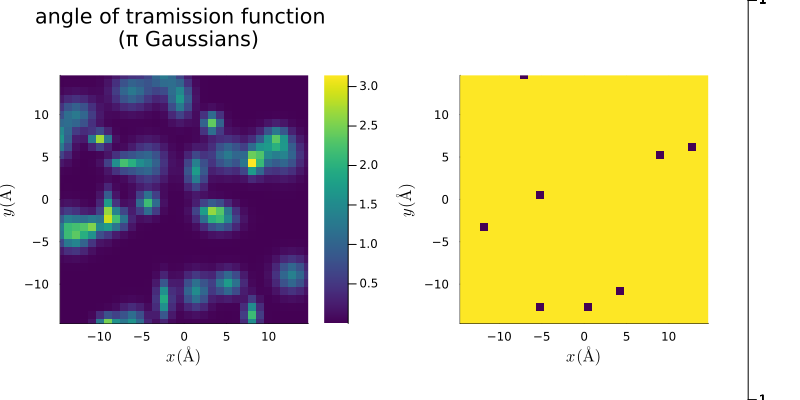

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY


In [11]:
S = 5
σ₊, σ₋ = 7, 7
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
# indices = round.(Int, LinRange(1, N, S))

# for i in indices, j in indices
#     xc = x[i]
#     yc = y[j]
#     phase_real += f(x',y, xc, yc, σ₊, σ₋)
#     phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
# end
xc, yc = 0.0, 0.0
σx, σy = 1, 7
θ_rot = deg2rad(0)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
Random.seed!(1)
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
for i in 1:30
    xc = rand(x)
    yc = rand(y)
    σx, σy = rand(Uniform(0.5, 1.5)), rand(Uniform(0.5, 1.5))
    phase_real += f(rotatedx,rotatedy, xc, yc, σx, σy)
    phase_complex += f(rotatedx,rotatedy, xc, yc, σx, σy) 
end
# phase_real = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)
# phase_complex = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real #+ 1im*phase_complex

transmission = @. cis(phase);


fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function \n (π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

fig2 = heatmap(x,y,abs.(transmission), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

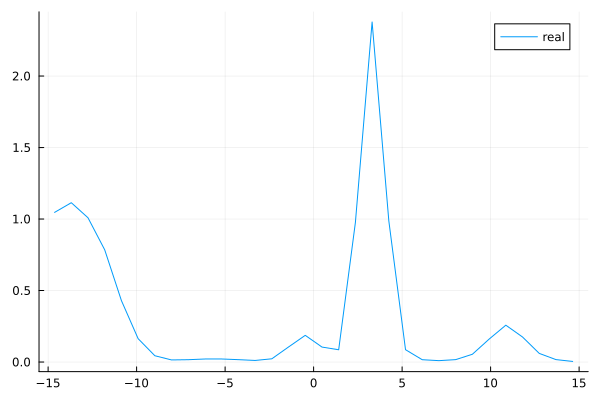

In [11]:
plot(x,phase_real[N÷2+10,:], label="real")

In [14]:
Reference_Wave(θ, φ) = @. cispi(2/kmax(E,Cs) * (sin(θ)*cos(φ)*x' + sin(θ)*sin(φ)*y))
wave_ref = ifftnshift(fftnshift(Reference_Wave(0.2, 0)).*H)
wave_ref = wave_ref./sqrt(sum(abs2.(wave_ref)))
transmission = @. exp(1im * phase);
heatmap(x, y, angle.(wave_ref), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);

In [16]:
probe = ifftnshift(H)
probe = probe./sqrt(sum(abs2.(probe)))
heatmap(x, y, abs.(probe), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);

In [17]:
raster_shifts = @. cispi(2*(kx' * x' + ky * y))

heatmap(x, y, angle.(raster_shifts), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=true, 
    xlabel="x", 
    ylabel="y");

In [18]:
function Rasters_fft(raster_shifts, tf_wave_fft, H)
    Ny, Nx = size(raster_shifts)
    # rasters_fft = Array{ComplexF64}(undef, N, N, N, N)
    common_factor = @. tf_wave_fft * H  # element-wise multiplication of tf_wave_fft and H
    rasters_fft = reshape(raster_shifts, Ny, Nx, 1, 1) .* reshape(common_factor, 1, 1, Ny, Nx)
    return rasters_fft
end

Rasters_fft (generic function with 1 method)

In [19]:
wave_obj_fft = fftnshift(transmission.*probe)
rasters_fft = Rasters_fft(raster_shifts, wave_obj_fft, H);

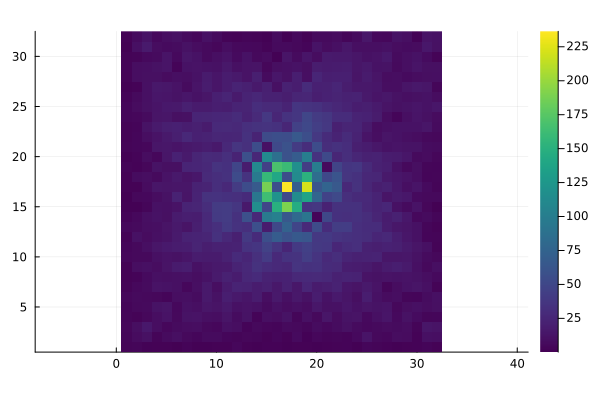

In [20]:
heatmap(abs.(ifftnshift(rasters_fft[1, 1, :, :])), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

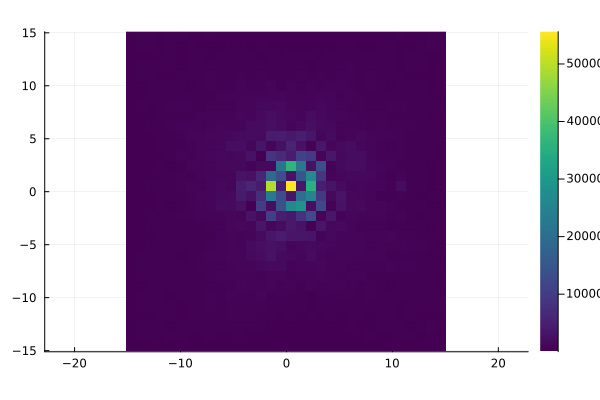

In [21]:

measurement(i,j) = abs2.(fftnshift(wave_ref.+ rasters_fft[i,j,:,:])) 
measurement_noisy(i,j,N_electrons=1e3,B=0.001) = Noisy_Image(measurement(i,j), N_electrons, B)


measurement_fft(i,j) = @. fftnshift(measurement_noisy(i,j))
measurement_autocorr(i,j) = Autocorrelation_Normalized(measurement(i,j))
heatmap(x, y, measurement(10,30), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(kx, ky, Diff_Image(measurement_fft(30,30)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true); 

In [23]:
plot(x,(measurement(N÷2+10,40)[N÷2+1,:]), label="real")

BoundsError: BoundsError: attempt to access 32×32×32×32 Array{ComplexF64, 4} at index [26, 40, 1:32, 1:32]

In [24]:
# measurement_noised = Array{Float64}(undef, N, N, N, N)
measurement_ideal = Array{Float64}(undef, N, N, N, N)
for i in 1:N, j in 1:N
    # measurement_noised[i,j,:,:] = Noisy_Image(measurement(i,j), 1e2, 0.01)
    measurement_ideal[i,j,:,:] = measurement(i,j)
end
# noised_reshaped = reshape(measurement_noised, N*N*N*N);
ideal_reshaped = reshape(measurement_ideal, N*N*N*N);

In [80]:
println(any(ideal_reshaped .<= 0.0)) 
println(any(isinf.(ideal_reshaped)))
println(any(isnan.(ideal_reshaped)))

false
false
false


In [82]:
# Round to the nearest integer and convert
loglik = logpdf.(Poisson.(ideal_reshaped), round.(Int, ideal_reshaped))

1048576-element Vector{Float64}:
 -1.905869500672635
 -1.905869500672635
 -1.9058695006726332
 -1.9058695006726332
 -1.905869500672635
 -1.9058695006726332
 -1.905869500672634
 -1.9058695006726332
 -1.905869500672635
 -1.905869500672635
  ⋮
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298
 -2.887570957563298

In [77]:
logpdf(Poisson(5.0), 5.0)    # Returns -Inf


-1.7403021806115442

In [73]:
logpdf.(Poisson.(ideal_reshaped), ideal_reshaped)

1048576-element Vector{Float64}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
   ⋮
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf

In [22]:
println(sum(measurement_noised[5,10,:,:]))
println(sum(measurement_ideal[1,1,:,:]))
sum(rand(Poisson(1), size(measurement_noised[5,10,:,:])))

UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

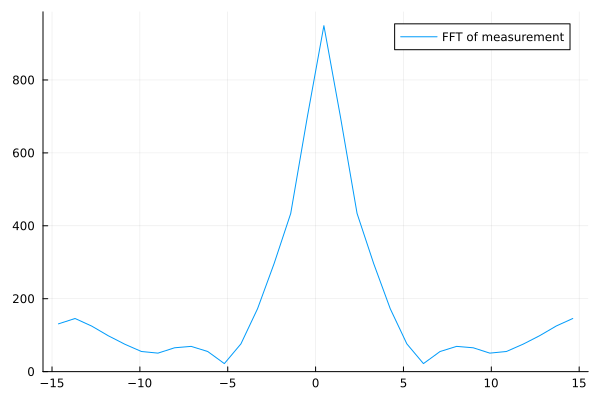

In [25]:
shift = -1
k, l = 25, 3
plot(x,abs.(measurement_fft(k,l)[N÷2-shift,:]), label="FFT of measurement", legend=:topright)
ylims!(0,maximum(abs.(measurement_fft(k,l)))*1)

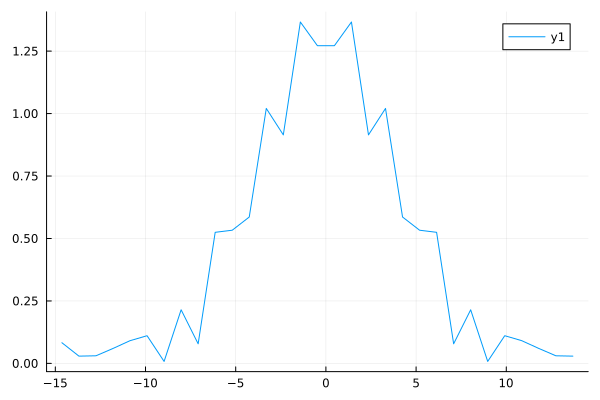

In [26]:
plot(x[1:end-1],Diff_Image(diff(abs.(measurement_fft(k,l)[N÷2-shift,:]))))

In [27]:
plot(x[1:end-2],Diff_Image(diff(diff(abs.(measurement_fft(k,l)[N÷2-shift,:])))));

In [28]:
println(Wavelength(E))

0.019686806700005176


In [97]:
# χ_array_alloc = Matrix{Float64}(undef, N, N)
function H_transfer(Cs, 
    k_grid=k,Energy::T=E, 
    bin_disk=disk, 
    λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}


# returns the transfer function H matrix
local χ = @. π*λ*k_grid^2*(0.5*Cs*λ^2*k_grid^2 - sqrt(3/2 * Cs * λ))

return @. cis(-χ*bin_disk)*bin_disk
# return @. phonycomplex(cos(χ*bin_disk)*bin_disk, sin(-χ*bin_disk)*bin_disk)
end





function wiggle_factor_2ndterm(θ,φ, 
            x::AbstractVector{T}=x, 
            y::AbstractVector{T}=y,
            Energy::T=E, 
            λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}

arg = @. 2*π*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y)
return @. cis(2*pi*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y))
# return @. phonycomplex(cos(arg), sin(arg))
end



function first_term(Cs,θ, φ,
    Energy::T = E,
    x::Vector{T}=x,
    y::Vector{T}=y) where {T<:AbstractFloat}

    # ref_wave = cispi(2/kmax(E,Cs) * (sin(θ)*cos(φ)*x' + sin(θ)*sin(φ)*y))
    arg = @. 2/kmax(Energy,Cs) * sin(θ) *(cos(φ)*x' + sin(φ)*y)
    wave_ref = @. cis(π*arg)
    wave_ref = ifftnshift(fftnshift(wave_ref).*H_transfer(Cs))

    # return wave_ref./sqrt(sum(abs2, wave_ref))
    norm_factor = sqrt(sum(abs2, wave_ref))
    
    # Use a loop-based normalization instead of broadcasting
    result = similar(wave_ref)
    for i in eachindex(wave_ref)
        result[i] = wave_ref[i] / norm_factor
    end
    # result = [wave_ref[i]/norm_factor for i in eachindex(wave_ref)]
    
    return result
end
# function second_term(Cs::T, θ::T, φ::T) where {T<:AbstractFloat}
#     return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# end
# function second_term(Cs::T, θ::T, φ::T)::Matrix{Complex{T}} where {T<:AbstractFloat}
# return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# # return h
# end
function second_term(Cs,ϕ::AbstractMatrix,
    θ,φ)::AbstractMatrix 


    probe = ifftnshift(H_transfer(Cs))
    norm_factor = sqrt(sum(abs2, probe))
    probe_copy = similar(probe)
    for i in eachindex(probe)
        probe_copy[i] = probe[i] / norm_factor
    end
    # probe_copy = [probe[i]/norm_factor for i in eachindex(probe)]
    # probe = probe./sqrt(sum(abs2,probe))
    return fftnshift(cis.(ϕ).*probe_copy).*H_transfer(Cs) 
# return fftnshift_custom(@. phonycomplex(cos(ϕ), sin(ϕ))*probe)*H_transfer(Cs) 
end
# probe = ifftnshift(H_transfer(Cs))
# probe = probe./sqrt(sum(abs2.(probe)))
# trasmission = @. exp(1im * phase);
# wave_obj_fft = fftnshift(transmission.*probe).*H_transfer(Cs)

second_term (generic function with 1 method)

In [50]:
# χ_array_alloc = Matrix{Float64}(undef, N, N)
function H_transfer(Cs, 
                    k_grid=k,Energy::T=E, 
                    bin_disk=disk, 
                    λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}


    # returns the transfer function H matrix
    local χ = @. π*λ*k_grid^2*(0.5*Cs*λ^2*k_grid^2 - sqrt(3/2 * Cs * λ))
    
    # return @. cis(-χ*bin_disk)*bin_disk
    return @. phonycomplex(cos(χ*bin_disk)*bin_disk, sin(-χ*bin_disk)*bin_disk)
end





function wiggle_factor_2ndterm(θ,φ, 
                            x::AbstractVector{T}=x, 
                            y::AbstractVector{T}=y,
                            Energy::T=E, 
                            λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}
    
    arg = @. 2*π*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y)
    # return @. cispi(2*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y))
    return @. phonycomplex(cos(arg), sin(arg))
end



function first_term(Cs,θ, φ,
                    Energy::T = E,
                    x::Vector{T}=x,
                    y::Vector{T}=y) where {T<:AbstractFloat}

    # ref_wave = cispi(2/kmax(E,Cs) * (sin(θ)*cos(φ)*x' + sin(θ)*sin(φ)*y))
    arg = @. 2/kmax(Energy,Cs) * sin(θ) *(cos(φ)*x' + sin(φ)*y)
    wave_ref = @. phonycomplex(cos(arg), sin(arg))
    wave_ref = ifftnshift_custom(fftnshift_custom(wave_ref).*H_transfer(Cs))
    norm = sqrt(sum(abs2, wave_ref))
    return wave_ref
end
# function second_term(Cs::T, θ::T, φ::T) where {T<:AbstractFloat}
#     return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# end
function second_term(Cs::T, θ::T, φ::T)::Matrix{Complex{T}} where {T<:AbstractFloat}
    return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
    # return h
end
function second_term(Cs,ϕ::AbstractMatrix,
                    θ,φ)::AbstractMatrix 
    
    
    probe = ifftnshift_custom(H_transfer(Cs))
    norm = sqrt(sum(abs2,probe))
    probe = probe
    # return fftnshift(cis.(ϕ).*probe).*H_transfer(Cs) 
    return fftnshift_custom(@. phonycomplex(cos(ϕ), sin(ϕ))*probe)*H_transfer(Cs) 
end
# probe = ifftnshift(H_transfer(Cs))
# probe = probe./sqrt(sum(abs2.(probe)))
# trasmission = @. exp(1im * phase);
# wave_obj_fft = fftnshift(transmission.*probe).*H_transfer(Cs)

second_term (generic function with 2 methods)

In [30]:
using Random
using Turing
using MCMCChains
# using Pigeons
using StatsPlots
using Distributions
using Pkg
# Pkg.add("AdvancedMH")
# Pkg.add("Pigeons")
# using AdvancedMH

In [30]:

Threads.nthreads()

8

In [31]:
using AdvancedHMC

In [123]:
# function Base.:/(a::AbstractMatrix{<:phonycomplex}, b::ReverseDiff.TrackedReal)
#     result = similar(a)
#     for i in eachindex(a)
#         result[i] = a[i] / b  # Element-wise division
#     end
#     return result
# end

# # Generic method to handle any tracked type
# function Base.:/(a::AbstractMatrix{<:phonycomplex}, b::Any)
#     result = similar(a)
#     for i in eachindex(a)
#         result[i] = a[i] / b  # Element-wise division
#     end
#     return result
# end
# import Base: /, broadcastable
# broadcastable(z::phonycomplex) = Ref(z)      # scalar broadcasting

# /(A::AbstractMatrix{<:phonycomplex}, b::Real) =
#     Base.Broadcast.materialize(Base.Broadcast.broadcasted(/, A, b))

# <-- phonycomplex definition (single type parameter, zero/one/promote_rule)
# broadcastable(z::phonycomplex) = Ref(z)
using ADTypes
using ReverseDiff
Random.seed!(1)  # For reproducibility
@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    # A ~ truncated(Normal(100, 15), 10, 200)
    # B ~ Uniform(0,0.1)
    Cs ~ Normal(1e7, 3e6)
    θ ~ truncated(Normal(0.1, 1), 0, 1)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(Uniform(0,π), Ny, Nx)


    # Likelihood
    wave_ref = first_term(Cs, θ, φ)
    wave_obj = reshape(wiggle_factor_2ndterm(θ,φ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, ϕ, θ, φ), 1, 1, Ny, Nx)

    # measurement_ideal = Array{Any}(undef, N, N, N, N)
    # for i in 1:Ny, j in 1:Nx
    #     measurement_ideal[i,j,:,:] = abs2.(fftnshift_custom(wave_ref .+ wave_obj[i,j,:,:]))
    # end
    measurement_ideal = [abs2.(fftnshift(wave_ref.+ wave_obj[i,j,:,:])) 
                     for i in 1:Ny, j in 1:Nx]
    # Use a list comprehension to create a flat vector
    # flattened_measurements = vcat([vec(abs2.(fftnshift(wave_ref.+ wave_obj[i,j,:,:]))) 
    # for i in 1:Ny, j in 1:Nx]...)

    # Apply Poisson to scalar values
    # y ~ arraydist(Poisson.(flattened_measurements))
    flattened_measurements = vcat(map(x -> vec(x), vec(measurement_ideal))...)
    y ~ arraydist(Poisson.(flattened_measurements))
    # y ~ arraydist(Poisson.(vec(measurement_ideal)))
    
end
# Generate synthetic data
n = 10

# Fit the model
initial_params = (Cs=1e7, θ=0.1, φ=0.0, ϕ=phase)
model = infinite_chain(round.(Int, ideal_reshaped))
# sampler = Turing.SGLD(; stepsize=0.01, adtype=AutoForwardDiff())
# sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
# using Zygote
# sampler = Turing.NUTS(max_depth=8; adtype=AutoZygote())
sampler = Turing.MH() # Metropolis-Hastings



chain = sample(model, sampler, n, initial_params=initial_params, progress=true)

# chain = sample(model, sampler, MCMCThreads(), n, 8, progress=true)
# Plot the results
# plot(x,y)

Sampling   0%|                                          |  ETA: N/A
Sampling  10%|████▎                                     |  ETA: 0:00:15
Sampling  20%|████████▍                                 |  ETA: 0:00:10
Sampling  30%|████████████▋                             |  ETA: 0:00:06
Sampling  40%|████████████████▊                         |  ETA: 0:00:05
Sampling  50%|█████████████████████                     |  ETA: 0:00:04
Sampling  60%|█████████████████████████▎                |  ETA: 0:00:03
Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:02
Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:01
Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:01
Sampling 100%|██████████████████████████████████████████| Time: 0:00:04
Sampling 100%|██████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (10×1028×1 Array{Float64, 3}):

Iterations        = 1:1:10
Number of chains  = 1
Samples per chain = 10
Wall duration     = 5.64 seconds
Compute duration  = 5.64 seconds
parameters        = Cs, θ, φ, ϕ[1, 1], ϕ[2, 1], ϕ[3, 1], ϕ[4, 1], ϕ[5, 1], ϕ[6, 1], ϕ[7, 1], ϕ[8, 1], ϕ[9, 1], ϕ[10, 1], ϕ[11, 1], ϕ[12, 1], ϕ[13, 1], ϕ[14, 1], ϕ[15, 1], ϕ[16, 1], ϕ[17, 1], ϕ[18, 1], ϕ[19, 1], ϕ[20, 1], ϕ[21, 1], ϕ[22, 1], ϕ[23, 1], ϕ[24, 1], ϕ[25, 1], ϕ[26, 1], ϕ[27, 1], ϕ[28, 1], ϕ[29, 1], ϕ[30, 1], ϕ[31, 1], ϕ[32, 1], ϕ[1, 2], ϕ[2, 2], ϕ[3, 2], ϕ[4, 2], ϕ[5, 2], ϕ[6, 2], ϕ[7, 2], ϕ[8, 2], ϕ[9, 2], ϕ[10, 2], ϕ[11, 2], ϕ[12, 2], ϕ[13, 2], ϕ[14, 2], ϕ[15, 2], ϕ[16, 2], ϕ[17, 2], ϕ[18, 2], ϕ[19, 2], ϕ[20, 2], ϕ[21, 2], ϕ[22, 2], ϕ[23, 2], ϕ[24, 2], ϕ[25, 2], ϕ[26, 2], ϕ[27, 2], ϕ[28, 2], ϕ[29, 2], ϕ[30, 2], ϕ[31, 2], ϕ[32, 2], ϕ[1, 3], ϕ[2, 3], ϕ[3, 3], ϕ[4, 3], ϕ[5, 3], ϕ[6, 3], ϕ[7, 3], ϕ[8, 3], ϕ[9, 3], ϕ[10, 3], ϕ[11, 3], ϕ[12, 3], ϕ[13, 3], ϕ[14, 3], ϕ[15, 3], ϕ[16, 3], ϕ[17, 3],

In [98]:
result = maximum_a_posteriori(model)
# result_mle = maximum_likelihood(model)

InterruptException: InterruptException:

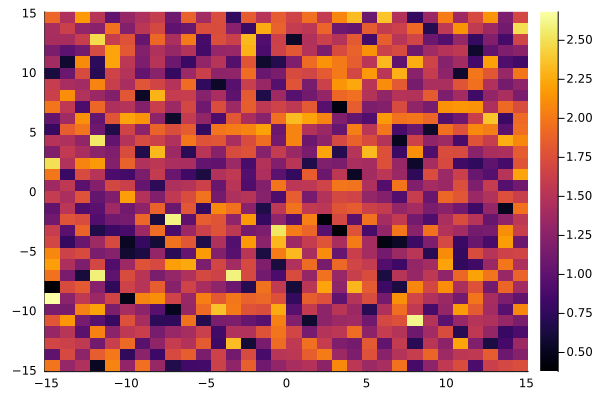

In [124]:
# If you're trying to reshape the phi parameters into a 2D field
phi_params = sum(Array(chain[1:end, 4:end, :]), dims=1)/size(chain, 1)
# phi_matrix = reshape(phi_params, N, N)  # Reshape to N×N grid
heatmap(x, y, phi_params)

In [103]:
A = chain[end,4:end,:]
# ϕ = reshape(A[5:end], N, N)
heatmap(x,y,A)

ErrorException: Cannot convert Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, @NamedTuple{parameters::Vector{Symbol}, internals::Vector{Symbol}}, @NamedTuple{varname_to_symbol::OrderedDict{AbstractPPL.VarName, Symbol}, start_time::Float64, stop_time::Float64}} to series data for plotting

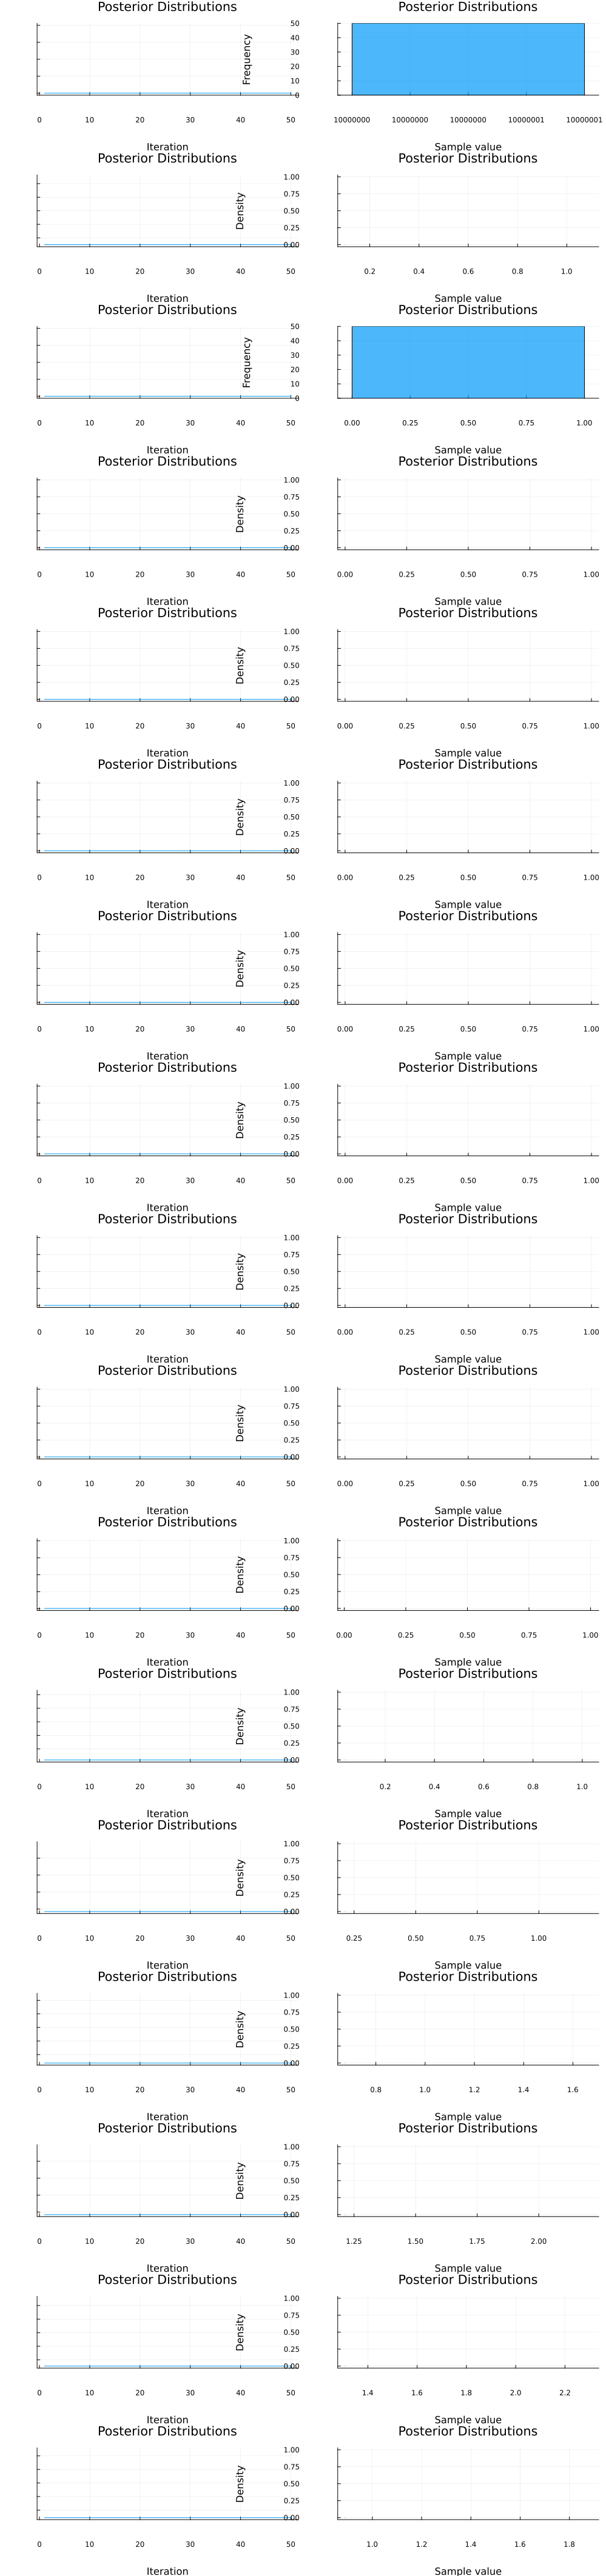

In [43]:
plot(chain[:,1:17,:], title="Posterior Distributions", legend=false)

In [34]:
plot(samples, title="Posterior Distributions", legend=false)

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
using Random, Distributions

In [36]:
# using Pkg
#using MCMCChains
using MCMCChains
using AdaptiveMCMC




λ_model_alloc = Array{Float64,4}(undef, N, N, N, N)
function log_likelihood(x::AbstractVector{T}, 
    data::typeof(measurement_noised)=measurement_ideal, 
    Nx=N, Ny=N, λ_model::typeof(λ_model_alloc)=λ_model_alloc)::T where {T<:AbstractFloat}

    
    B_shift, B_scale = 0.1, 0.1
    B = B_shift + B_scale*x[end]
    B_logpdf = logpdf(truncated(Normal(B_shift, B_scale), 0, 2), B)
    B_logpdf += log10(B_scale)

    Cs_shift, Cs_scale = 1e7, 3e6
    Cs = Cs_shift + Cs_scale*x[end-1]
    Cs_logpdf = logpdf(truncated(Normal(Cs_shift, Cs_scale), 0, Inf), Cs)
    Cs_logpdf += log10(Cs_scale)

    θ_shift, θ_scale = 0.1, 0.1
    θ = θ_shift + θ_scale*x[end-2]
    θ_logpdf = logpdf(truncated(Normal(θ_shift, θ_scale), 0, 1), θ)
    θ_logpdf += log10(θ_scale)

    φ_shift, φ_scale = 0.0, 0.1
    φ = φ_shift + φ_scale*x[end-3]
    φ_logpdf = logpdf(Normal(φ_shift, φ_scale), φ)
    φ_logpdf += log10(φ_scale)

    
    # ϕ = reshape(x[1:Nx*Ny], Ny, Nx)
    # ϕ_logpdf = sum(logpdf.(Uniform(-0.1, π/2 + 0.1), ϕ))
    ϕ_lower, ϕ_upper = -0.1, π/2 + 0.1
    rawϕ = view(x, 1:Nx*Ny)
    ϕ = ϕ_lower .+ (ϕ_upper-ϕ_lower).*cdf.(Normal(), rawϕ)
    ϕ = reshape(ϕ, Ny, Nx)
    ϕ_logpdf = -Nx*Ny*log10(ϕ_upper-ϕ_lower)   # constant Jacobian term
    # if !isfinite(B_logpdf) || !isfinite(Cs_logpdf) || !isfinite(θ_logpdf) || !isfinite(φ_logpdf) == 0 || ϕ_logpdf == 0
    #     return -Inf
    # end
    
    
    λ_model .= abs2.(
        reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
                reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
                .+ B
    
    return sum(data.*log10.(λ_model) - λ_model) + B_logpdf + Cs_logpdf + θ_logpdf + φ_logpdf + ϕ_logpdf
end




function parallel_rwm()
    Ny, Nx = N, N
    x0 = zeros(Ny*Nx + 4)
    # x0[end] = 0.1
    # x0[end-1] = 0.0
    # x0[end-2] = 0.1
    # x0[end-3] = 0.0
    n = 50
    thining = 3
    burn_in = n÷2
    interations = (n-burn_in)÷thining + 1
    n_chains = 10

    rwm_chains_parallel = Array{Float64, 3}(undef, interations, length(x0), n_chains)
    Threads.@threads for i in 1:n_chains
        rwm_chains_parallel[:, :, i] = Transpose(adaptive_rwm(x0, log_likelihood, n; 
                                                thin=thining, L=2, b=burn_in,
                                                algorithm=:asm, 
                                                swaps =:nonrev)[1])
    end
    return rwm_chains_parallel
end
rwm_chains_parallel = parallel_rwm();



UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [37]:
# using Pkg
#using MCMCChains
using MCMCChains
using AdaptiveMCMC




λ_model_alloc = Array{Float64,4}(undef, N, N, N, N)
function log_likelihood(x::AbstractVector{T}, 
    data::typeof(measurement_noised)=measurement_ideal, 
    Nx=N, Ny=N, λ_model::typeof(λ_model_alloc)=λ_model_alloc)::T where {T<:AbstractFloat}

    
    B = x[end]
    Cs = x[end-1]
    θ = x[end-2]
    φ = x[end-3]

    B_logpdf = logpdf(truncated(Normal(0.1, 0.1), 0, 2), B)
    
    Cs_logpdf = logpdf(truncated(Normal(1e7, 1e6), 0, Inf), Cs)
    
    θ_logpdf = logpdf(truncated(Normal(0.1, 0.1), 0, 1), θ)
    
    φ_logpdf = logpdf(Normal(0.1, 0.1), φ)
    

    
    ϕ = reshape(x[1:Nx*Ny], Ny, Nx)
    ϕ_logpdf = sum(logpdf.(Uniform(-0.1, π/2 + 0.1), ϕ))
    
    
    
    
    λ_model .= abs2.(
        reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
                reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
                .+ B
    
    return sum(data.*log10.(λ_model) - λ_model) + B_logpdf + Cs_logpdf + θ_logpdf + φ_logpdf + ϕ_logpdf
end




function parallel_rwm()
    Ny, Nx = N, N
    x0 = zeros(Ny*Nx + 4)
    # x0[end] = 0.1
    # x0[end-1] = 0.0
    # x0[end-2] = 0.1
    # x0[end-3] = 0.0
    n = 50
    thining = 3
    burn_in = n÷2
    interations = (n-burn_in)÷thining + 1
    n_chains = 10

    rwm_chains_parallel = Array{Float64, 3}(undef, interations, length(x0), n_chains)
    Threads.@threads for i in 1:n_chains
        rwm_chains_parallel[:, :, i] = Transpose(adaptive_rwm(x0, log_likelihood, n; 
                                                thin=thining, L=2, b=burn_in,
                                                algorithm=:asm, 
                                                swaps =:nonrev)[1])
    end
    return rwm_chains_parallel
end
rwm_chains_parallel = parallel_rwm();



UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
@benchmark log_likelihood(x0)

LoadError: LoadError: UndefVarError: `@benchmark` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /home/nicolas/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X51sZmlsZQ==.jl:1

In [39]:
@benchmark log_likelihood(zeros(N*N+4))

LoadError: LoadError: UndefVarError: `@benchmark` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /home/nicolas/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:1

In [40]:
ϕ = reshape(x0[1:Nx*Ny], Ny, Nx)
φ = x0[end-3]      
θ = abs(x0[end-2])
Cs = abs(x0[end-1])
# @btime first_term(Cs, ϕ);

UndefVarError: UndefVarError: `x0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [41]:
samples = Chains(rwm_chains_parallel)

UndefVarError: UndefVarError: `rwm_chains_parallel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [42]:
plot(samples[:,1:4,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")
# plot(samples[:,end-3:end,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [43]:
plot(samples[:,end÷2:end÷2+5,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [44]:
summaries, quantiles = describe(samples)

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
summaries

UndefVarError: UndefVarError: `summaries` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
plot(chain[:,10:14,:])

UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main

In [47]:
# Suppose you want the first element of φ for each sample:
plot(chain[:, ["B", "Cs", "θ", "φ"], :], seriestype=:trace, title="Trace Plots")# plot(chain, seriestype=:density, title="Density Plots")


UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main